# Convex hull as an index to support an algorithm for the mutualisation of itineraires
to see it renderd visit https://nbviewer.org/github/Universite-Gustave-Eiffel/geodev-logicout/blob/main/notebooks/convex_hull.ipynb

In [1]:
import sys  
sys.path.insert(0, '../scripts')
import indexes, use_data, IsInclude
from shapely import wkt
import geopandas as gpd
import seaborn as sns
import numpy as np
import aux_plot


In [2]:
# we initialize the parameters for the geodataframe
radius=100000
buffer_hull= 1000
type= 1
geo_df= use_data.create_gdf('simulations_reel_gdf.csv','cheflieu')

### We will take some itineraires and their mutualisables itineraires as examples to visualize how the convexes hulls behaves

Number of labels: 100


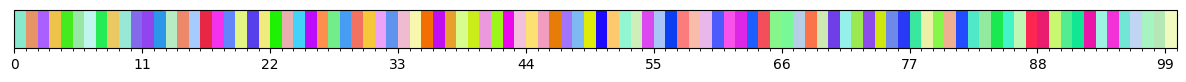

In [3]:
sample1=geo_df.iloc[[5]] #we choose a sample itineraire as a sample

sample_map, sample_gdf =aux_plot.map_gdf_mutualisables(sample1,geo_df)


In [4]:
sample_map # in black the itineraire of the chosen sample


We can also choose a sample by the simulation's Id

Number of labels: 100


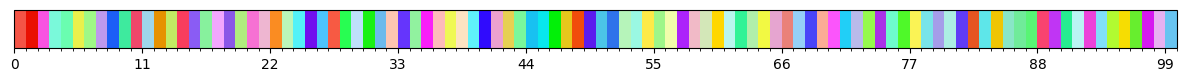

In [5]:
sample2 = use_data.get_itineraire(640,geo_df)
sample2_map, sample2_dataframe = aux_plot.map_gdf_mutualisables(sample2,geo_df)

Let's look at their convex hulls within a radius of 1km of the lines representing the itineraires

In [6]:
sample2_gdf= IsInclude.IsIn_tournee_gdf(sample2,geo_df,radius,type)
sample2_envelopes = indexes.jacaard_index(sample2, sample2_gdf,buffer_hull)
sample2 = gpd.GeoDataFrame(sample2,geometry=sample2['itineraire'].map(wkt.loads)) # type: ignore
sample2 = gpd.GeoDataFrame(sample2,geometry=sample2.geometry.buffer(1000).convex_hull) # type: ignore

In [7]:
m = sample2_envelopes.explore(
   tiles='CartoDB positron', column='id_simulation_right', categorical=True,style_kwds=dict(fill=True, stroke=True,weight=2))
m = sample2.explore( m=m,tiles='CartoDB positron',style_kwds=dict(fill=True,opacity=0.5, stroke=True,weight=4,color='black'))

In [8]:
m # in black the hull of the chosen sample

### Quantification of convex hulls overlays

In [11]:
# the Jaacard's index gives an measure of similarity between two sets. If the sets are disjoints, the index is 0, and If they're the same, the index is 1.
sample2_envelopes['jaacard'].describe()

count    32.000000
mean      0.001758
std       0.006645
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.028652
Name: jaacard, dtype: float64

For this sample this index seems to be usefull for the purpose of selecting the best pairs of itineraires. 
It may miss itineraires that doesn't forcefully intersect each others but that could have been enchained.
Let's see how well it behaves for all the db.

In [10]:
#this takes aproximatly 3 minutes to run
import pandas as pd
from tqdm import tqdm
empty_list=[]
for i in tqdm(range (geo_df.shape[0])):
    gdf= IsInclude.IsIn_tournee_gdf(geo_df.iloc[[i]],geo_df,radius,type)
    gdf = indexes.jacaard_index(geo_df.iloc[[i]], gdf,buffer_hull)
    empty_list = empty_list + gdf.values.tolist()

    
df = pd.DataFrame (empty_list, columns = ['id_simulation','id_simulation_right','itineraire_right','start_right','union_area','intersection_area','geometry','jaacard'])

df_not_null = df[df['jaacard']!=0]



100%|██████████| 1097/1097 [02:36<00:00,  7.01it/s]


In [11]:
jacard_table=df.groupby('id_simulation')
jacard_table['jaacard'].count()

id_simulation
349       69
466      110
473      110
474      110
483      110
        ... 
18917    177
18918    177
18919    177
18920    177
18935    158
Name: jaacard, Length: 1097, dtype: int64

In [12]:
jacard_table_not_null=df_not_null.groupby('id_simulation')
jacard_table_not_null['jaacard'].count()

id_simulation
349       6
473      11
474       5
483      13
640       3
         ..
18917    44
18918    31
18919    56
18920    38
18935    20
Name: jaacard, Length: 1025, dtype: int64

Roughly 7% of the database's entries didn't have any non-zero value. As for the others, the quantity of potentially mutualisables itineraires has been greatly reduced. !!!NOTE:  Before changing the settings of the database filtering to accept a mutualisation for the same id of user and rejecting mutualisations with the same starting point this result was 19%


In [14]:
print('Total of mutualisation searched: {0}'.format(df.shape[0]))
print('Total of mutualisation searched with jacaard index > 0: {0}'.format(df_not_null.shape[0]))
print(df_not_null.shape[0]/(df.shape[0]+df_not_null.shape[0]))

Total of mutualisation searched: 92648
Total of mutualisation searched with jacaard index > 0: 22839
0.1977625187250513


### Plot of the distributions of the jacaard indexes

[Text(0.5, 1.0, 'Valid mutualisations considering all entries')]

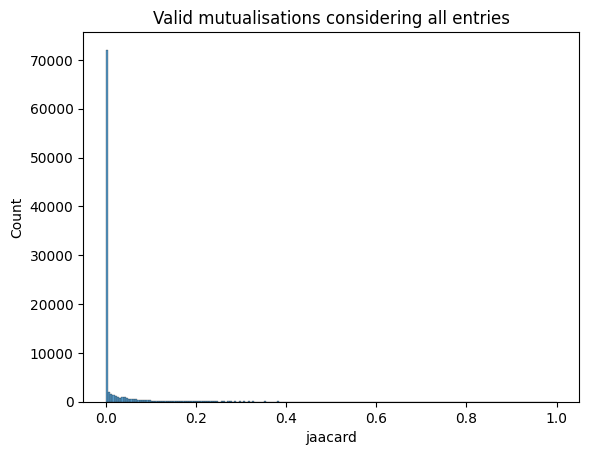

In [15]:
df_histo=df[['id_simulation','jaacard']]
sns.histplot(data=df_histo,x="jaacard", legend=False,binwidth=0.005).set(title='Valid mutualisations considering all entries')

[Text(0.5, 1.0, 'Valid mutualisations considering all entries with jacaard index > 0')]

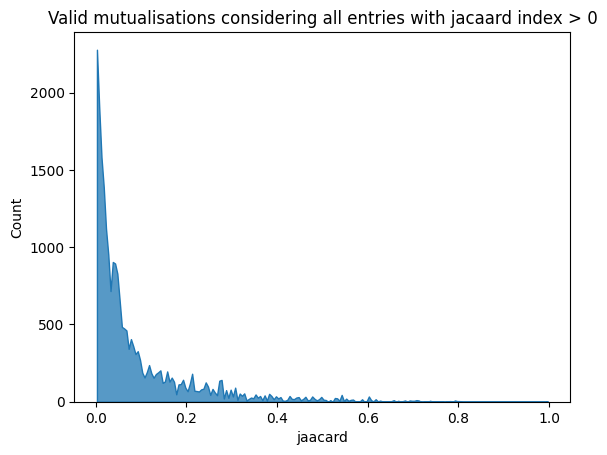

In [16]:

df_histo_not_null=df_not_null[['id_simulation','jaacard']]
sns.histplot(data=df_histo_not_null,x="jaacard", element="poly", legend=False,binwidth=0.005).set(title='Valid mutualisations considering all entries with jacaard index > 0')

We can inspect the list of itineraires that don't have any overlapping convex hull

In [17]:
jaacard_full=jacard_table.count().index.values
jacaard_not_empty=jacard_table_not_null.count().index.values
difference = np.setdiff1d(jaacard_full,jacaard_not_empty)
difference


array([  466,   727,   938,   999,  1000,  1362,  1704,  2088,  3074,
        4136,  4137,  4220,  4853,  5031,  5045,  6084,  6235,  6241,
        6244,  6254,  6260,  6261,  6289,  6293,  6299,  6300,  6307,
        6321,  6322,  7269,  8161,  8983,  9275,  9287,  9306, 11269,
       11280, 11619, 11634, 11635, 11636, 11637, 12185, 12187, 12192,
       12194, 12195, 12204, 12206, 12209, 12212, 12214, 12221, 12225,
       12226, 12227, 12229, 15189, 16048, 16051, 16052, 16053, 16055,
       16057, 16058, 16059, 16266, 16377, 16379, 17285, 17609, 18832])

Let's see the simulation with id 466

Number of labels: 100


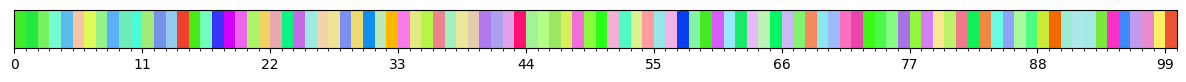

In [36]:
sample3 = use_data.get_itineraire(938,geo_df)
sample3_map, sample3_dataframe =  aux_plot.map_gdf_mutualisables(sample3,geo_df)

sample3_gdf= IsInclude.IsIn_tournee_gdf(sample3,geo_df,radius,type)
sample3_envelopes = indexes.jacaard_index(sample3, sample3_gdf,buffer_hull)
sample3 = gpd.GeoDataFrame(sample3,geometry=sample3['itineraire'].map(wkt.loads)) 
sample3 = gpd.GeoDataFrame(sample3,geometry=sample3.geometry.buffer(1000).convex_hull) 

m = sample3_envelopes.explore(
    tiles='CartoDB positron', column='id_simulation_right', categorical=True,style_kwds=dict(fill=True, stroke=True,weight=2))
m = sample3.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=True,opacity=0.5, stroke=True,weight=4,color='black'))


In [37]:
m # in black the hull of the chosen sample

Considering this simulations and others, we can think that the index based in the overlapping's convex hulls can be useful but it's not enough to find the best pairs of itineraires, so it should be used to complement other strategies. 
Nonetheless, it could have a high covariance with others indexes of similarity and thus not being highly effective.